In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Overview

**Basic imports**

In [2]:
import pandas as pd
import numpy as np

from Bio import SeqIO
from matplotlib import pyplot as plt

import sklearn.metrics

from scipy import stats
import glob

**Custom imports**

In [3]:
import process_couplings

**Plotting parameters**

In [4]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

**Creating a folder to store results. This should be adjusted based on how you want to store figures (if at all). Relevant variable is: `figs_dir`**

In [5]:
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

**Finally, some directory variables and constants to apply throughout**

In [6]:
couplings_dir = '../Results/couplings/'
contacts_dir = '../Data/psicov150_aln_pdb/pdb/'
fastas_dir = '../Data/psicov150_aln_pdb/aln_fasta_max1k/'

In [7]:
length_based_modifier = 1.

primary_distance_cutoff = 6

contact_definition = 7.5 

# Visualize some generalities

**Distributions of coupling values**

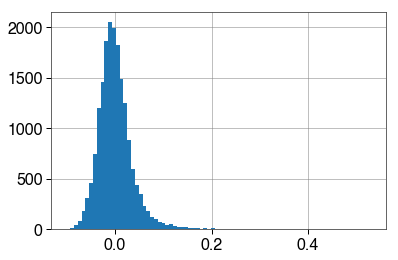

In [8]:
prot_name = '1aoeA'

# testy_df = process_couplings.process_ccmpredpy(couplings_dir+'{}.raw.uniform.mat'.format(prot_name))
# testy_df = process_couplings.process_ccmpredpy(couplings_dir+'{}.ent.uniform.mat'.format(prot_name))
testy_df = process_couplings.process_ccmpredpy(couplings_dir+'{}.apc.uniform.mat'.format(prot_name))

# testy_df = process_couplings.process_ccmpredpy(couplings_dir+'{}.raw.GSC_meanScale.mat'.format(prot_name))
# testy_df = process_couplings.process_ccmpredpy(couplings_dir+'{}.ent.GSC_meanScale.mat'.format(prot_name))
# testy_df = process_couplings.process_ccmpredpy(couplings_dir+'{}.apc.GSC_meanScale.mat'.format(prot_name))



fig, ax = plt.subplots()
ax.hist(testy_df['couplings'], 80);

**Load in a contact file and test PPV**

In [9]:
df_contacts = pd.read_csv(contacts_dir+'{}_SCcenter_contacts.csv'.format(prot_name), index_col=0)
df_contacts, df_contacts_stack = process_couplings.process_contacts_df(df_contacts)
seq = list(SeqIO.parse(fastas_dir+'{}.fasta'.format(prot_name), 'fasta'))[0]
seq = str(seq.seq)
df_merged = process_couplings.merge_contacts_couplings(df_contacts_stack, testy_df, seq)
df_merged = process_couplings.remove_close(df_merged, primary_distance_cutoff)

print(process_couplings.ppv_from_df(df_merged, int(len(seq)*length_based_modifier), length_cutoff=contact_definition))

(0.4270833333333333, 192)


**And visualize the precision-recall curve**

Average precision: 0.21896121007531077


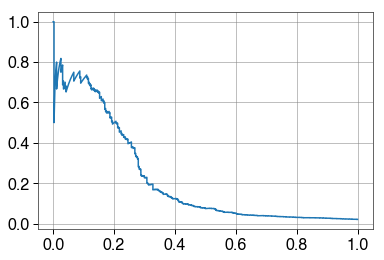

In [11]:
df_merged['contact'] = df_merged['distance']<=contact_definition
aupr = sklearn.metrics.average_precision_score(df_merged['contact'], df_merged['couplings'])
precision, recall, trash = sklearn.metrics.precision_recall_curve(df_merged['contact'], df_merged['couplings'])

fig, ax = plt.subplots()
ax.plot(recall, precision)
print('Average precision:', aupr)

# Systematic-ish

**If run on the entire results set this will take a while and eat up a lot of memory. Can be modified to only read in certain types or proteins if necessary but currently this will take it all in**

In [12]:
results_dicty_ppv = {}
results_dicty_aupr = {}

types_to_test = ['raw', 'apc', 'ent']

for type_to_test in types_to_test:
    for infile in sorted(glob.glob(couplings_dir+'*.mat'))[:]:
        prot_name = infile.split('/')[-1].split('.')[0]
        params = '.'.join(infile.split('/')[-1].split('.')[1:-1])
        if params[:3] != type_to_test:
            continue
        #Read in the couplings for the protein of interest
        testy_df = process_couplings.process_ccmpredpy(infile)
        #Read in the contacts
        df_contacts = pd.read_csv(contacts_dir+'{}_SCcenter_contacts.csv'.format(prot_name), index_col=0)
        df_contacts, df_contacts_stack = process_couplings.process_contacts_df(df_contacts)
        #Read in the fasta sequence
        seq = list(SeqIO.parse(fastas_dir+'{}.fasta'.format(prot_name), 'fasta'))[0]
        seq = str(seq.seq)
        #Merge everyone together
        df_merged = process_couplings.merge_contacts_couplings(df_contacts_stack, testy_df, seq)
        #Remove pairs that are close in primary distance space
        df_merged = process_couplings.remove_close(df_merged, primary_distance_cutoff)
        #Calculate the PPV and add to a results dictionary
        ppv_val, ns = process_couplings.ppv_from_df(df_merged, int(len(seq)*length_based_modifier),\
                                                    length_cutoff=contact_definition)
        try:
            results_dicty_ppv[params].append(ppv_val)
        except:
            results_dicty_ppv[params] = [ppv_val]
        #########
        #Further process the merged dataframe to include a binary variable for contacts
        df_merged['contact'] = df_merged['distance']<contact_definition
        #Calculate the area under the curve and add to a results dictionary
        aupr = sklearn.metrics.average_precision_score(df_merged['contact'], df_merged['couplings'])
        try:
            results_dicty_aupr[params].append(aupr)
        except:
            results_dicty_aupr[params] = [aupr]

**See what method/s were best!**

In [ ]:
best_results = []
for key, val in results_dicty_ppv.items():
#     if key[:3] == 'raw':
        best_results.append((key, np.median(val)))
best_results = sorted(best_results, key=lambda x: x[1], reverse=True)
best_results

# Visualizing 

**Setting some variables here that can be toggled to analyze a different set of results**

In [13]:
coup_type = 'apc'
#
#
#
#
results_dicty = results_dicty_ppv
metric = 'PPV'
#
# results_dicty = results_dicty_aupr
# metric = 'AUPR'

** Boxplot with means **

Not the cleanest code, but gets the job done for a pretty-ish plot

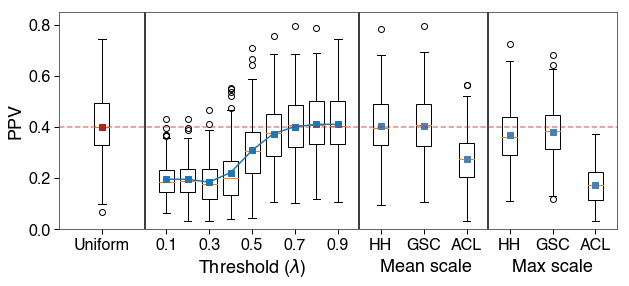

In [14]:
coup_type = 'apc'

#Getting in all the data
data = [results_dicty['{}.uniform'.format(coup_type)]]+\
[results_dicty['{}.simple_0.{}'.format(coup_type, i)] for i in range(1,10)]+\
[results_dicty['{}.HH_meanScale'.format(coup_type)]]+\
[results_dicty['{}.GSC_meanScale'.format(coup_type)]]+\
[results_dicty['{}.ACL_meanScale'.format(coup_type)]]+\
[results_dicty['{}.HH_maxScale'.format(coup_type)]]+\
[results_dicty['{}.GSC_maxScale'.format(coup_type)]]+\
[results_dicty['{}.ACL_maxScale'.format(coup_type)]]

#My x-labels get a bit complicated because of the nature of the plot
labels = ['Uniform']+[str(i/10) for i in range(1, 10, 2)]+['HH', 'GSC', 'ACL']+['HH', 'GSC', 'ACL']
xvals= [-0.1]+[i/10 for i in range(2,11)]+[i/10 for i in range(12, 18, 2)]+[i/10 for i in range(18, 24, 2)]


fig, ax = plt.subplots(figsize=(10,4))
bplot = ax.boxplot(data, positions=xvals, widths=(0.07), patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor('white')
#Drawing some lines to divide the plot up a bit
ax.axvline(0.1, c='k')
ax.axvline(1.1, c='k')
ax.axvline(1.7, c='k')
#Some work with the x-axis
ax.set_xlim(-0.3, 2.3)
ax.set_xticks([-0.1]+[0.2, 0.4, 0.6, 0.8, 1.0]+[1.2, 1.4, 1.6]+[1.8, 2.0, 2.2])
ax.set_xticklabels(labels)

#Now setting up to plot the means in a hideous manner
data = [np.mean(results_dicty['{}.simple_0.{}'.format(coup_type, i)]) for i in range(1,10)]
xvals= [i/10 for i in range(2,11)]
ax.plot([-0.1], [np.mean(results_dicty['{}.uniform'.format(coup_type)])], marker='s', zorder=3, c='firebrick')
ax.axhline(np.mean(results_dicty['{}.uniform'.format(coup_type)]), linestyle='--', c='firebrick', alpha=0.5, zorder=4)
ax.plot(xvals, data, marker='s', zorder=3)
ax.plot([1.2], [np.mean(results_dicty['{}.HH_meanScale'.format(coup_type)])], marker='s', zorder=3, c='steelblue')
ax.plot([1.4], [np.mean(results_dicty['{}.GSC_meanScale'.format(coup_type)])], marker='s', zorder=3, c='steelblue')
ax.plot([1.6], [np.mean(results_dicty['{}.ACL_meanScale'.format(coup_type)])], marker='s', zorder=3, c='steelblue')
ax.plot([1.8], [np.mean(results_dicty['{}.HH_maxScale'.format(coup_type)])], marker='s', zorder=3, c='steelblue')
ax.plot([2.0], [np.mean(results_dicty['{}.GSC_maxScale'.format(coup_type)])], marker='s', zorder=3, c='steelblue')
ax.plot([2.2], [np.mean(results_dicty['{}.ACL_maxScale'.format(coup_type)])], marker='s', zorder=3, c='steelblue')

ax.set_ylabel(metric)
###This had to be done because of some annoying quirk with Affinity Design which I used to layout the final figures
ax.set_xlabel('Threshold ($\lambda$)',\
              horizontalalignment='left', x=0.25)
ax.text(0.575, -0.135, 'Mean scale        Max scale', transform=ax.transAxes, fontsize=18,
        verticalalignment='top')
ax.set_ylim(0, 0.85)
ax.grid(False)
# plt.savefig('{}/{}_summary.pdf'.format(figs_dir, coup_type), bbox_inches='tight')

**Check statistics on any comparison using the wilcoxon signed-rank test (a paired, non-parametric test)**

In [50]:
# compare_a = 'raw.uniform'
compare_a = 'apc.uniform'
# compare_a = 'raw.uniform'
# compare_b = 'apc.GSC_meanScale'
# compare_a = 'apc.uniform'
compare_b = 'apc.simple_0.9'
# compare_b = 'apc.simpleish_0.8'
# compare_b = 'apc.simple_0.7'
# compare_b = 'apc.GSC_meanScale.RelTime'
# compare_b = 'apc.HH_meanScale'


print(compare_a, np.mean(results_dicty[compare_a]), np.median(results_dicty[compare_a]))
print(compare_b, np.mean(results_dicty[compare_b]), np.median(results_dicty[compare_b]))
print('Significance:', stats.wilcoxon(results_dicty[compare_a], results_dicty[compare_b]))

apc.uniform 0.40136604568848616 0.3983402489626556
apc.simple_0.9 0.4102995783450379 0.40425531914893614
Significance: WilcoxonResult(statistic=1322.5, pvalue=1.94955461495613e-08)


In [51]:
#For the order of magnitude changes
print(np.median(np.array(results_dicty[compare_b])/np.array(results_dicty[compare_a])))

1.0116279069767442


**Comparing modified identity-based method with the original identity-based method**

9 6


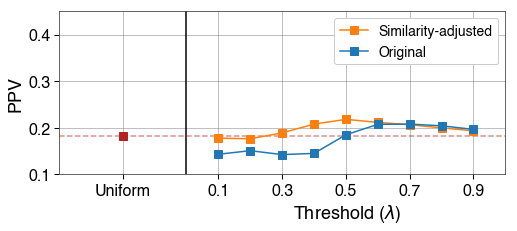

In [28]:
coup_type = 'raw'
labels = ['Uniform']+[str(i/10) for i in range(1, 10, 2)]
print(len(data), len(labels))
xvals= [-0.1]+[i/10 for i in range(2,11)]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(8,3))
ax.set_xlim(-0.3, 1.1)
ax.set_xticks([-0.1]+[0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(labels)
ax.axvline(0.1, c='k')
ax.plot([-0.1], [np.mean(results_dicty['{}.uniform'.format(coup_type)])], marker='s', zorder=3, c='firebrick', markersize=8)
ax.axhline(np.mean(results_dicty['{}.uniform'.format(coup_type)]), linestyle='--', c='firebrick', alpha=0.5, zorder=4)
data = [np.mean(results_dicty['{}.simpleish_0.{}'.format(coup_type, i)]) for i in range(1,10)]
xvals= [i/10 for i in range(2,11)]
ax.plot(xvals, data, marker='s', zorder=4, label='Similarity-adjusted', markersize=8, c=colors[1])

data = [np.mean(results_dicty['{}.simple_0.{}'.format(coup_type, i)]) for i in range(1,10)]
xvals= [i/10 for i in range(2,11)]
ax.plot(xvals, data, marker='s', zorder=4, label='Original', markersize=8, c=colors[0])

ax.set_ylabel(metric)
ax.set_xlabel('Threshold ($\lambda$)',\
              horizontalalignment='left', x=0.525)
ax.set_ylim(0.1, 0.45)
legend = ax.legend(loc=1, fontsize=14, framealpha=1.0)
plt.savefig('{}/{}_identity_compare.pdf'.format(figs_dir, coup_type), bbox_inches='tight')
# ax.grid(False)

**Comparing weights computed from regular trees vs RelTime trees**

In [ ]:
coup_type = 'apc'
x_vals = [-0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 0.9, 1.1, 1.2]

labels = ['Uniform'] +['Raw tree', 'RelTime tree']*4

colors = ['firebrick'] + ['steelblue', 'darkorange']*4
y_vals = [np.mean(results_dicty['{}.uniform'.format(coup_type)]),\
         np.mean(results_dicty['{}.GSC_meanScale'.format(coup_type)]),\
         np.mean(results_dicty['{}.GSC_meanScale.RelTime'.format(coup_type)]),\
         np.mean(results_dicty['{}.ACL_meanScale'.format(coup_type)]),\
         np.mean(results_dicty['{}.ACL_meanScale.RelTime'.format(coup_type)]),\
         np.mean(results_dicty['{}.GSC_maxScale'.format(coup_type)]),\
         np.mean(results_dicty['{}.GSC_maxScale.RelTime'.format(coup_type)]),\
         np.mean(results_dicty['{}.ACL_maxScale'.format(coup_type)]),\
         np.mean(results_dicty['{}.ACL_maxScale.RelTime'.format(coup_type)])]
y_errs = [np.std(results_dicty['{}.uniform'.format(coup_type)]),\
         np.std(results_dicty['{}.GSC_meanScale'.format(coup_type)]),\
         np.std(results_dicty['{}.GSC_meanScale.RelTime'.format(coup_type)]),\
         np.std(results_dicty['{}.ACL_meanScale'.format(coup_type)]),\
         np.std(results_dicty['{}.ACL_meanScale.RelTime'.format(coup_type)]),\
         np.std(results_dicty['{}.GSC_maxScale'.format(coup_type)]),\
         np.std(results_dicty['{}.GSC_maxScale.RelTime'.format(coup_type)]),\
         np.std(results_dicty['{}.ACL_maxScale'.format(coup_type)]),\
         np.std(results_dicty['{}.ACL_maxScale.RelTime'.format(coup_type)])]

fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlim(-0.3, 1.35)
ax.errorbar(x_vals[:1], y_vals[:1], yerr=y_errs[:1], marker='s', markersize=10,\
            linestyle='', c='firebrick')
ax.errorbar(x_vals[1::2], y_vals[1::2], yerr=y_errs[1::2], marker='s', markersize=10,\
            linestyle='', c='steelblue', zorder=4)
ax.errorbar(x_vals[2::2], y_vals[2::2], yerr=y_errs[2::2], marker='s', markersize=10,\
            linestyle='', c='darkorange', zorder=4)

ax.plot(x_vals[1::2], y_vals[1::2], marker='s', markersize=10,\
            linestyle='', c='steelblue', label='Raw tree', zorder=4)
ax.plot(x_vals[2::2], y_vals[2::2], marker='s', markersize=10,\
            linestyle='', c='darkorange', label='RelTime tree', zorder=4)

ax.axvline(0.1, c='k')
ax.axhline(np.mean(results_dicty['{}.uniform'.format(coup_type)]), linestyle='--', c='firebrick', alpha=0.5, zorder=4)

leg = ax.legend(loc='center left', bbox_to_anchor=(0.22, 1.1), ncol=2, fontsize=14)
ax.set_xticks([-0.1]+[0.25, 0.55, 0.85, 1.15])
ax.set_xticklabels(['Uniform', 'GSC', 'ACL', 'GSC', 'ACL'])
ax.set_xlabel('Mean scale       Max scale',\
              horizontalalignment='left', x=0.28)
ax.set_ylim(0, 0.58)
ax.set_ylabel('PPV')
plt.savefig('{}/{}_RelTime.pdf'.format(figs_dir, coup_type), bbox_inches='tight')
# ax.grid(False)

# DEPRECATED

**Below code was not used for manuscript but left here for posterity.**

**Was attempting to code/test my own APC and entropy-corrections from the raw coupling data to make sure that I understood the way that the methods worked but in the end just used the files outputted by CCMPredPy**

In [ ]:
prot_name = '1aoeA'
testy_df = process_couplings.process_ccmpredpy('../Results/couplings/{}.raw.GSC_meanScale.mat'.format(prot_name))
apc_df = process_couplings.process_ccmpredpy('../Results/couplings/{}.apc.GSC_meanScale.mat'.format(prot_name))

In [ ]:
testy_df.head()

In [ ]:
temp_row = {}
for i in list(set(list(testy_df['aa1_loc'])+list(testy_df['aa2_loc']))):
    temp_df = testy_df[(testy_df['aa1_loc'] == i) | (testy_df['aa2_loc'] == i)]
    temp_row[i] = np.mean(temp_df['couplings'])
testy_df['apc'] = np.nan
cmean = np.mean(testy_df['couplings'])
for index in testy_df.index:
    coupling = testy_df.loc[index]['couplings']
    ci = temp_row[testy_df.loc[index]['aa1_loc']]
    cj = temp_row[testy_df.loc[index]['aa2_loc']]
    testy_df.set_value(index, 'apc',coupling - ((ci*cj)/cmean))

In [ ]:
fig, ax = plt.subplots()
ax.plot(testy_df['couplings'], testy_df['apc'], 'bo')
fig, ax = plt.subplots()
ax.plot(apc_df['couplings'], testy_df['apc'], 'bo')

In [ ]:
stats.linregress(apc_df['couplings'], testy_df['apc'])

**Ents**

In [ ]:
from Bio.Alphabet.IUPAC import IUPACProtein
IUPACProtein.letters

In [ ]:
def sequence_entropy_from_msa(msa_file, weights_file=False, base=2, skip_gaps=False):
    '''
    This should calculate the (un)weighted sequence entropy directly from a fasta file.
    If not provided, all weights are even. If provided, weights will be read directly
    from the accompanying weights_file.
    
    '''
    
    alignment = SeqIO.parse(msa_file, format='fasta')
    aln_mat = np.array([list(i.seq) for i in alignment])
    
    #####################
    #####################
    for i in IUPACProtein.letters:
        aln_mat = np.append(aln_mat, [list(i*aln_mat.shape[1])], axis=0)
    #####################
    #####################

    aln_mat_T = aln_mat.T
    
    if weights_file:
        weights = np.genfromtxt(weights_file)
    else:
        weights = np.ones(aln_mat_T[0].shape)
    
    initial_shape = aln_mat_T.shape
    flat_seqs = aln_mat_T.flatten()
    order, flat_array = np.unique(flat_seqs, return_inverse=True)
    if '-' in order:
        assert order[0] == '-'
    else:
        if skip_gaps:
            skip_gaps = False
            print('No gapped characters found in alignment, skip_gaps flag is meaningless')

    replaced_seqs_T = flat_array.reshape(initial_shape)
    
    ents_all = []
    for aln_position in replaced_seqs_T:
        if skip_gaps:
            ents_all.append(stats.entropy(np.bincount(aln_position,\
                                    weights=weights, minlength=21)[1:], base=base))
        else:
            ents_all.append(stats.entropy(np.bincount(aln_position,\
                                    weights=weights, minlength=21), base=base))   
    return ents_all

In [ ]:
prot_name = '1aoeA'

testy_df = process_couplings.process_ccmpredpy('../Results/couplings/{}.raw.uniform.mat'.format(prot_name))
ent_df = process_couplings.process_ccmpredpy('../Results/couplings/{}.ent.uniform.mat'.format(prot_name))

msa_file = '../../Phylogenetic_couplings/Data/'\
                'psicov150_aln_pdb/aln_fasta_max1k/{}.fasta'.format(prot_name)
emp_entropies = sequence_entropy_from_msa(msa_file, skip_gaps=False, base=2)

# msa_file = '../../Phylogenetic_couplings/Data/'\
#                 'psicov150_aln_pdb/aln_fasta_max1k/{}.fasta'.format(prot_name)
# weights_file = '../../DCA_weighting/Data/{}.HH.test'.format(prot_name)
# emp_entropies = sequence_entropy_from_msa(msa_file,\
#                                           weights_file=weights_file, skip_gaps=False, base=2)




testy_df['score_h'] = np.nan
testy_df['first_h'] = np.nan
testy_df['second_h'] = np.nan

for index in testy_df.index:
    fr = emp_entropies[int(testy_df.loc[index]['aa1_loc'])-1]
    sr = emp_entropies[int(testy_df.loc[index]['aa2_loc'])-1]
    testy_df.set_value(index, 'score_h', (fr**(1/2))*(sr**(1/2)))
    testy_df.set_value(index, 'first_h', fr)
    testy_df.set_value(index, 'second_h', sr)

# ###########
alpha_1 = np.sum(testy_df['couplings']*testy_df['score_h'])
alpha_2 = np.sum(testy_df['first_h'] * testy_df['second_h'])
alpha = alpha_1/alpha_2
testy_df['couplings_ent'] = testy_df['couplings'] - (alpha * testy_df['score_h'])
# ###########
###########



In [ ]:
fig, ax = plt.subplots()
ax.plot(testy_df['couplings_ent'], ent_df['couplings'], 'bo')

stats.linregress(testy_df['couplings_ent'], ent_df['couplings'])

In [ ]:
df_contacts = pd.read_csv('../../Phylogenetic_couplings/Data/'
                          'psicov150_aln_pdb/pdb/{}_CB_contacts.csv'.format(prot_name), index_col=0)
df_contacts, df_contacts_stack = process_couplings.process_contacts_df(df_contacts, 1)
seq = list(SeqIO.parse('../../Phylogenetic_couplings/Data/'
                       'psicov150_aln_pdb/aln_fasta/{}.fasta'.format(prot_name), 'fasta'))[0]
seq = str(seq.seq)
df_merged = process_couplings.merge_contacts_couplings(df_contacts_stack, ent_df, seq)
df_merged['contact'] = df_merged['distance']<7.5
aupr = sklearn.metrics.average_precision_score(df_merged['contact'], df_merged['couplings'])
print(aupr)

In [ ]:
hmmm = pd.concat([df_merged, testy_df['couplings_ent']],\
                      axis=1, join_axes=[df_merged.index])
hmmm.sort_values('couplings_ent', ascending=False, inplace=True)

In [ ]:
aupr = sklearn.metrics.average_precision_score(hmmm['contact'], hmmm['couplings_ent'])
print(aupr)